In [1]:
!pip install git+https://github.com/openai/CLIP.git
!pip install git+https://github.com/facebookresearch/segment-anything.git
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-8ev6bb1l
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-8ev6bb1l
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.2 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=10bb5a9a57cad7d0e8690aba5a98e5145aecb4612e2479b61afad715ae0ae597
  Stored in directory: /tmp/pip-ephem-wheel-cache-f7k5y6co/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-afwt3

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Pour récupérer l'image
import requests

# Pour la manipulation des images
from PIL import Image
import cv2

import torch

# Modèle CLIP d'OpenAI
import clip
# Modèle CLIPSeg pour la Prompt Segmentation
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
# Modèle SAM de Meta
from segment_anything import sam_model_registry, SamPredictor

2023-04-16 14:57:41.998693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 14:57:42.353578: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gs/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-04-16 14:57:42.353621: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-16 14:57:43.541566: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: 

In [2]:
# Définition du device: idéalement GPU
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Chargement du modèle CLIP
modelClip, preprocessClip = clip.load("ViT-B/32", device=device)

In [4]:
# Chargement du modèle CLIPSeg
processorCLIPSeg = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
modelCLIPSeg = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [5]:
# Chargement du modèle SAM: doit être localement dans le dossier d'exécution du notebook

# Modèle "léger"
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

# Modèle "lourd"
#sam_checkpoint = "sam_vit_h_4b8939.pth"
#model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

On doit ici jongler entre deux formats d'images:
- Le format PIL est utilisé dans les modèles CLIP et CLIPSeg et dans Matplotlib
- Le format CV2 est utilisé dans le modèle SAM et pour la gestion des flux vidéos

In [6]:
# Conversion Image au format CV2 -> Image au format PIL
def cvToPil(cv2_im):
    cv2_im=cv2.cvtColor(cv2_im,cv2.COLOR_BGR2RGB)
    return Image.fromarray(cv2_im)

In [7]:
# Conversion Image au format PIL -> Image au format CV2
def pilToCv(Pil_im):
    image=cv2.cvtColor(np.array(Pil_im), cv2.COLOR_RGB2BGR)
    return image

On traitera ci-dessous l'image suivante:

In [8]:
url = "https://github.com/timojl/clipseg/blob/master/example_image.jpg?raw=true"
imagePil = Image.open(requests.get(url, stream=True).raw)
imagecv = pilToCv(imagePil)

On convertit l'image au format PIL avant de l'afficher via pyplot:

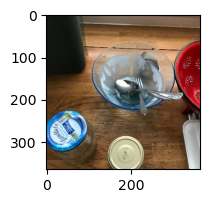

In [9]:
plt.figure(figsize=(2,2))
plt.imshow(cvToPil(imagecv))
plt.show()

Dans la fonction suivante on demande au modèle CLIP d'arbitrer probabilistement entre la description donnée dans la variable `description` et une description "passe-partout", ici `"a photo"`. Cela semble assez bien marcher mais peut-être d'autres description "passe-partout" conviendrait mieux, suivant les contextes d'utilisation.

In [10]:
# Fonction (image,texte) -> probabilité de conjonction de l'image et du texte
# Variable Image au format CV2
# Variable description est un string
def verifDescription(image,description):
    # Conversion de l'image au format PIL
    image=cvToPil(image)
    # Preprocessing de l'image et fabrication d'un batch [image]
    imageClipPrep = preprocessClip(image).unsqueeze(0).to(device)
    # Tokenisation du text
    tokens = clip.tokenize([description, "a photo"]).to(device)
    with torch.no_grad():
        #image_features = modelClip.encode_image(imageClipPrep)
        #text_features = modelClip.encode_text(tokens)
        logits_per_image, logits_per_text = modelClip(imageClipPrep, tokens)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    return float(probs[0][0])

Par exemple:

In [11]:
description="a tiger"
verifDescription(imagecv,description)

0.22159306704998016

In [12]:
description="a cup"
verifDescription(imagecv,description)

0.9718406796455383

Définissons maintenant les fonctions de segmentation utilisant le modèle CLIPSeg.

Ce modèle prend en entrée une description et retourne basiquement une segmentation, plus précisément une probabilité de présence pour chaque pixel de l'image de départ.

In [13]:
# Fonction (image,description) -> Image de détection de la description
def probImageFromDescription(image,description):
    image=cvToPil(image)
    inputs = processorCLIPSeg(text=[description], images=[image], padding="max_length", return_tensors="pt")
    with torch.no_grad():
        outputs = modelCLIPSeg(**inputs)

    preds = outputs.logits
    mask=torch.sigmoid(preds)
    return cv2.resize(np.array(mask),image.size)

Un exemple du rendu de la fonction `probImageFromDescription`:

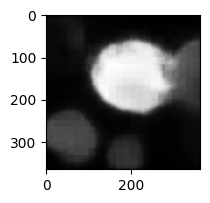

In [15]:
description="a cup"
probImage=probImageFromDescription(imagecv,description)
plt.figure(figsize=(2,2))
plt.imshow(probImage,cmap="gray")
plt.show()

In [16]:
# Fonction (image,description) -> point de l'image de probabilité maximale pour la description
def pointFromDescription(image,description):
    # On récupère l'image des probabilité
    mask=probImageFromDescription(image,description)
    # On prend le point de probabilité maximale
    input_point=np.unravel_index(np.argmax(mask), np.array(mask).shape)
    # On retourne ce point (inversion des x et des y par la fonction unravel_index)
    return np.array([[input_point[1],input_point[0]]])

In [17]:
# Fonction "de confort" pour afficher un point sur une figure matplotlib
def show_points(coords, ax, marker_size=375):
    pos_points = coords
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

Un exemple d'utilisation des fonctions `pointFromDescription` et `show_point`:

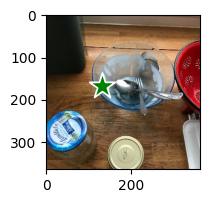

In [18]:
description="a cup"
point=pointFromDescription(imagecv,description)
plt.figure(figsize=(2,2))
plt.imshow(cvToPil(imagecv))
show_points(point,plt.gca())
plt.show()

In [19]:
# Fonction (image,description,seuil) -> masque de présence de l'objet conforme à la description
def basicMaskFromDescription(image,description,seuil):
    mask=probImageFromDescription(image,description)
    gray_image=np.array(mask * 255, dtype = np.uint8)
    (thresh, bw_image) = cv2.threshold(gray_image, seuil, 255, cv2.THRESH_BINARY)
    return bw_image>0

Un exemple d'utilisation de la fonction `basicMaskFromDescription`:

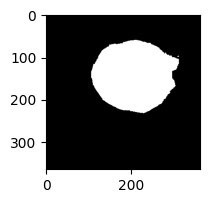

In [20]:
description="a cup"
maskImage=basicMaskFromDescription(imagecv,description,100)
plt.figure(figsize=(2,2))
plt.imshow(maskImage,cmap="gray")
plt.show()

On définit maintenant des fonctions utilisant le modèle SAM de Meta.

Ce modèle prend en entrée un point et retourne la segmentation de l'objet présent en ce point.

In [21]:
# Fonction (image,point) -> image mask de l'objet au point fourni
def maskFromPoint(image,input_point):
    # Pré-traitement de l'image par SAM
    predictor.set_image(image)
    # 2 labels possibles dans SAM: 1->le masque doit contenir ce point // 0->le masque ne doit pas contenir ce point
    input_label = np.array([1])
    # Calcul du masque
    mask, score, logit = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )
    # SAM retourne plusieurs masques possibles: on donne celui de plus grande proba
    return mask.squeeze()

Pour obtenir un masque à partir d'une description avec SAM on utilise alors le modèle CLIPSeg pour obtenir le point de plus grande probabilité de présence pour ensuite obtenir un masque avec SAM:

In [22]:
# Fonction (image,description) -> image mask correspondant à la description
def maskFromDescription(image,description):
    input_point = pointFromDescription(image,description)
    return maskFromPoint(image,input_point)

Un exemple d'utilisation de la fonction `maskFromDescription`:

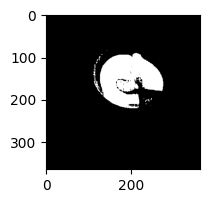

In [23]:
description="a cup"
maskImage=maskFromDescription(imagecv,description)
plt.figure(figsize=(2,2))
plt.imshow(maskImage,cmap="gray")
plt.show()

Fonction pour afficher les masques en surrimpression:

In [24]:
# Fonction (image,mask,color) -> image avec masque en surrimpression et de couleur donnée
def getMaskedImage(imagecv,mask,color=(0,0,255)):
    # On crée une image de même dimension que imagecv et de couleur color
    plein = np.zeros(imagecv.shape, imagecv.dtype)
    plein[:,:] = color
    # On colorise notre image msk
    maskIm = cv2.bitwise_and(plein, plein, mask=mask.astype(np.uint8))
    # Onretourne l'addition de maskIm et de imagecv
    return cv2.addWeighted(maskIm, 1, imagecv, 1,0)

Exemple d'utilisation avec le modèle CLIPSeg:

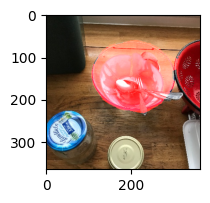

In [25]:
description="a cup"
basicMask=basicMaskFromDescription(imagecv,description,100)
maskedIm=getMaskedImage(imagecv,basicMask)
plt.figure(figsize=(2,2))
plt.imshow(cvToPil(maskedIm))
plt.show()

Exemple d'utilisation avec le modèle SAM:

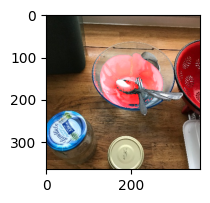

In [26]:
description="a cup"
mask=maskFromDescription(imagecv,description)
plt.figure(figsize=(2,2))
maskedIm=getMaskedImage(imagecv,mask)
plt.imshow(cvToPil(maskedIm))
plt.show() 